# Assignment 2: Emotion Classification

In [52]:
#all dependencies

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import tensorflow as tf

from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /Users/ygao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [32]:
#constants
DATA_LOCATION = '../data/go_emotions_dataset.csv'
CLEAN_DATA_LOCATION = '../data/'
MODEL_LOCATION = '../model/'
RANDOM_SEED = 297
CATEGORIES = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion',
              'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 
              'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 
              'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']

# Data preparation

We load the data from local source, and split it into train validation and test sets. 
Split corpus and target.

In [38]:
#load dataset
def load_data(filename):
    df = pd.read_csv(filename)
    df_raw_data = df.drop(columns=['id', 'example_very_unclear']) #text+categories
    category_columns = df_raw_data.columns[1:29] #extract categories
    df_data = pd.DataFrame({ #creating new df with 'text' and 'target
        'text': df_raw_data['text'],
        'target': df_raw_data[category_columns].apply(lambda row: row.values.tolist(), axis=1)
    })
    return df_data

df = load_data(DATA_LOCATION)

In [39]:
#split dataset into train, validation, test (70% 15% 15%)
#train: 147857 validation/test: 31684
df_train, df_temp = train_test_split(df, test_size=0.3, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=RANDOM_SEED)
#save the split data frames to csv just in case
df_train.to_csv(CLEAN_DATA_LOCATION+'raw_train.csv', index=False)
df_val.to_csv(CLEAN_DATA_LOCATION+'raw_val.csv', index=False)
df_test.to_csv(CLEAN_DATA_LOCATION+'raw_test.csv', index=False)

We have a closer look at the training set to see if the data is balanced. As it turns out the data contains a lot of neutral posts. There are several ways to deal with this class imbalance. We could undersample the overrepresented class; we could also adjust class weights; or we could use model such as Random Forests which is not sensitive to class imbalance. 

note: we can discuss this later

Possible sentiments are [list([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
 list([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
 list([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])
 ...
 list([1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
 list([1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
 list([1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])] of 1701 sentiments
The number of posts for training is 147857


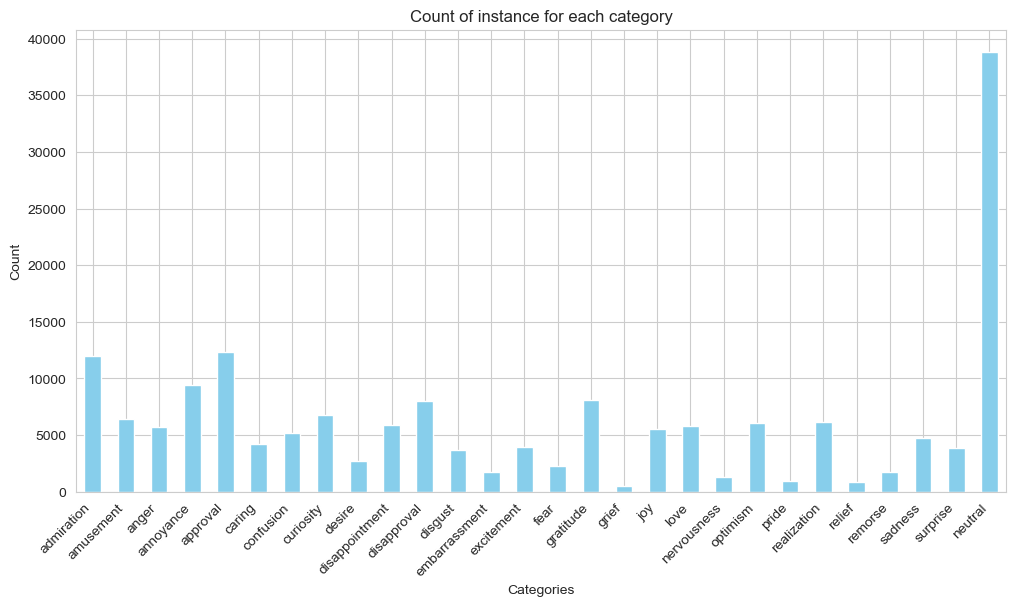

,raw text example
0,Right? Considering it’s such an important docu...


In [51]:
print("Possible sentiments are", np.unique(df_train['target']), "of", len(np.unique(df_train['target'])),"sentiments")
print("The number of posts for training is", len(df_train))

#visualize distribution
df_train_cat_binary = pd.DataFrame(df_train['target'].tolist(), columns=CATEGORIES)
df_train_visual = df_train_cat_binary.sum()

plt.figure(figsize=(12, 6))
df_train_visual.plot(kind='bar', color='skyblue')
plt.title('Count of instance for each category')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

#split into corpus and target
corpus_train = df_train['text']
target_train = df_train['target']

track = pd.DataFrame([corpus_train[5]], columns=["raw text example"]) #use to track progress
track.head()

Now we clean up the text to get clean tokens. 

In [ ]:
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

#code copied from internet. 
#haven't got a chance to look closely. 
#do not take seriously

# Defining a Function to clean up the reviews 
def text_preprocess(ds: pd.Series) -> pd.Series:
    """
    Apply NLP Preprocessing Techniques to the reviews.
    """
    for m in range(len(ds)):
        
        main_words = re.sub('[^a-zA-Z]', ' ', ds[m])    # Retain only alphabets
        main_words = (main_words.lower()).split()
        main_words = [w for w in main_words if not w in set(stop_words)]  # Remove stopwords
        
        main_words = [lemmatizer.lemmatize(w) for w in main_words if len(w) > 1]    # Group different forms of the same word
        
        main_words = ' '.join(main_words)
        ds[m] = main_words

    return ds



# Preprocessing